# 🎵 MPD Spotify Playlist Recommender System 🎵
The playlist recommendation task in recommender systems aims to suggest songs to complete a partial playlist. Given a set of playlists and their associated tracks, the goal is to predict which songs a user would add to an incomplete playlist based on historical data.

## Table of Contents 📖

1. **Dataset Analysis 📊**  
   Understanding the dataset structure, exploring distributions, and identifying key patterns for playlist recommendations.  

2. **Matrix Factorization Approach 🔢**  
   Implementing **Non-negative Matrix Factorization (NMF)** and **Singular Value Decomposition (SVD)** to uncover latent patterns in user-playlist interactions.  

3. **Language Model Approach 🧠**  
   Leveraging techniques to model playlists as sequences, predicting missing tracks using a character(tracks)-based Language Model.  

In [ ]:
#@title Import dependencies
import os
import re
import gc
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.decomposition import NMF
from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns


np.random.seed(42)

In [ ]:
# @title Download dataset from Kaggle
import kagglehub

path = "/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1"
if not os.path.exists(path):
  # Download latest version
  path = kagglehub.dataset_download("himanshuwagh/spotify-million")

# contiene le slices del dataset: 1000 slice das 1000 playlist ciascuna
data: str = os.path.join(path, "data")

# 🔍 Dataset Analysis

## What type of data do we have?

In [ ]:
shuffled_slices = np.array(os.listdir(data))
np.random.shuffle(shuffled_slices)

print("Slices: ", shuffled_slices[:3])

Slices:  ['mpd.slice.93000-93999.json' 'mpd.slice.946000-946999.json'
 'mpd.slice.194000-194999.json']


In [ ]:
with open(os.path.join(data, shuffled_slices[0]), 'r') as f:
  example_slice = json.load(f)

In [ ]:
print(list(example_slice['playlists'][0].keys()))
print(list(example_slice['playlists'][0]['tracks'][0].keys()))
print('\nFirst song of the first playlist:')
example_slice['playlists'][0]['tracks'][0]

['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'tracks', 'num_edits', 'duration_ms', 'num_artists']
['pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']

First song of the first playlist:


{'pos': 0,
 'artist_name': 'Lee Greenwood',
 'track_uri': 'spotify:track:1xcDKZqyEg1dIgsidluiFP',
 'artist_uri': 'spotify:artist:3g229vTyhsdwm9SO2p1FPL',
 'track_name': 'God Bless The U.S.A.',
 'album_uri': 'spotify:album:4b5VS7H0TqAEOrRF3Ax8s9',
 'duration_ms': 190240,
 'album_name': 'Greatest Hits - Volume 2'}

The raw dataset contains a total of 1 Million playlists splitted in 1000 slices with 1000 playlist each.

## Data Information from stats.txt

In [ ]:
stats_path = os.path.join(path, 'stats.txt')
with open(stats_path, 'r') as f:
    stats = f.read()
print(stats.split("numedits histogram")[0])
del stats


number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
number of playlists with descriptions 18760
number of unique normalized titles 17381
avg playlist length 66.346428

top playlist titles
  10000 country
  10000 chill
   8493 rap
   8481 workout
   8146 oldies
   8015 christmas
   6848 rock
   6157 party
   5883 throwback
   5063 jams
   5052 worship
   4907 summer
   4677 feels
   4612 new
   4186 disney
   4124 lit
   4030 throwbacks
   3886 music
   3513 sleep
   3500 vibes

top tracks
  46574 HUMBLE. by Kendrick Lamar
  43447 One Dance by Drake
  41309 Broccoli (feat. Lil Yachty) by DRAM
  41079 Closer by The Chainsmokers
  39987 Congratulations by Post Malone
  35202 Caroline by Aminé
  35138 iSpy (feat. Lil Yachty) by KYLE
  34999 Bad and Boujee (feat. Lil Uzi Vert) by Migos
  34990 Location by Khalid
  34922 XO TOUR Llif3 by Lil Uzi Vert
  33699 Bounce 

  - Dataset Scale 📊

      With 1,000,000 playlists and 66M track occurrences, this dataset is extensive, offering a rich base for modeling playlist recommendations. The number of unique tracks (2.26M) suggests a high diversity, obviously some tracks are likely to appear in multiple playlists.



  - Average Playlist Length 📏

      With an average length of ~66 tracks, playlists are relatively long, which could be beneficial for learning user preferences but may also introduce noise if playlists aren't highly curated.

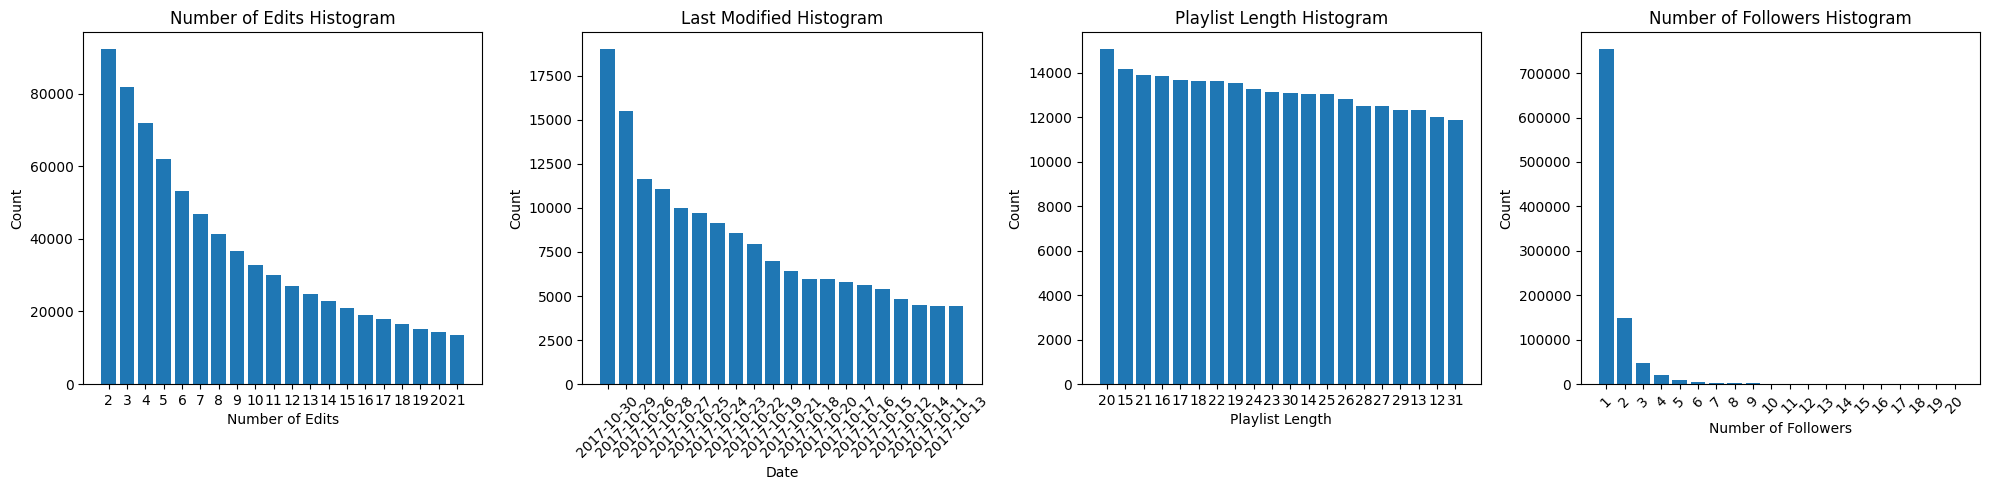

In [ ]:
# @title Plot stats

stats_lines = []
with open(stats_path, 'r') as f:
    stats_lines = f.readlines()

def parse_histogram(stats_lines, start_marker, end_marker=None):
    data = []
    recording = False
    for line in stats_lines:
        if start_marker in line:
            recording = True
            continue
        if end_marker and end_marker in line:
            break
        if recording:
            parts = line.strip().split()
            if len(parts) == 2:
                count, value = int(parts[0]), parts[1]
                data.append((value, count))
            elif len(parts) == 3:  # per gestire i casi "value value count"
                count = int(parts[-1])
                value = " ".join(parts[:-1])
                data.append((value, count))
    return data

# estraiamo gli istogrammi
numedits_histogram = parse_histogram(stats_lines, 'numedits histogram', 'last modified histogram')
last_modified_histogram = parse_histogram(stats_lines, 'last modified histogram', 'playlist length histogram')
playlist_length_histogram = parse_histogram(stats_lines, 'playlist length histogram', 'num followers histogram')
num_followers_histogram = parse_histogram(stats_lines, 'num followers histogram')

def plot_histograms(histograms, titles, xlabels, ylabels, rotations):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes = axes.flatten()  # in caso avessimo shape diversi della grid dei plot

    for i, ax in enumerate(axes):
        if i < len(histograms):
            data = histograms[i]
            values, counts = zip(*data)
            ax.bar(values, counts, align='center')
            ax.set_title(titles[i])
            ax.set_xlabel(xlabels[i])
            ax.set_ylabel(ylabels[i])
            ax.tick_params(axis='x', rotation=rotations[i])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# dati utili per il plot
histograms = [numedits_histogram, last_modified_histogram,
              playlist_length_histogram, num_followers_histogram]
titles = ['Number of Edits Histogram','Last Modified Histogram',
          'Playlist Length Histogram','Number of Followers Histogram']
xlabels = ['Number of Edits', 'Date', 'Playlist Length', 'Number of Followers']
ylabels = ['Count', 'Count', 'Count', 'Count']
rotations = [0, 45, 0, 45]

plot_histograms(histograms, titles, xlabels, ylabels, rotations)

# ⚡Matrix Factorization Approach

## Dataset Handling for Matrix Factorization
The following code efficiently processes **a partial number of slices** containing playlists and tracks, extracting relevant data while optimizing performance. Below is a breakdown of the key steps:

### **1. Initializing Storage 🗂️**  
- An **empty DataFrame (`million_df`)** is created to store playlist-track relationships.  
- A **list (`data_list`)** is used as a temporary storage to avoid frequent DataFrame modifications (which are costly).  


### **2. Batch Processing for Speedup 🚀**  
- Every **30 files**, the accumulated data is converted into a **DataFrame** and appended to `million_df`.  
- The **temporary list (`data_list`) is cleared** to free memory.  
- This approach prevents excessive memory consumption and improves runtime performance.   

### **Key Optimizations ✅**  
🔹 **Batch updates every 30 files** instead of appending row-by-row.  
🔹 **Memory-efficient types (`int32` for playlist IDs)**.  
🔹 **String cleaning (`track_uri[14:]`)** to extract meaningful track IDs.  

This method ensures **efficient data handling** while working with a large dataset of playlists and tracks. 🎶📊

In [ ]:
million_df = pd.DataFrame()
num_training_files = 500

# Create an empty list to hold all rows as dictionaries
data_list = []

for i, filename in tqdm(enumerate(shuffled_slices[:num_training_files]), desc="Processing Slices", total=num_training_files):
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
        filepath = os.path.join(data, filename)

        with open(filepath, "r", encoding="utf-8") as jsonfile:
            cur_slice = json.load(jsonfile)

        for playlist in cur_slice["playlists"]:
            playlist_id = playlist["pid"]

            # Collect data for the playlist
            for track in playlist["tracks"]:
                data_list.append({
                    "playlist": playlist_id,
                    "track": track["track_uri"][14:]  # remove 'spotify:track:'
                })

    # update every 30 files for speedup
    if i%30 == 0:
        new_data = pd.DataFrame(data_list)
        data_list.clear()
        million_df = pd.concat([million_df, new_data], ignore_index=True)

# Convert the list of dictionaries into a DataFrame in one go
new_data = pd.DataFrame(data_list)
data_list = []
million_df = pd.concat([million_df, new_data], ignore_index=True)

million_df["playlist"] = million_df["playlist"].astype("int32")

Processing Slices: 100%|██████████| 500/500 [05:00<00:00,  1.67it/s]


In [ ]:
million_df = million_df.drop_duplicates()

In [ ]:
million_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32775485 entries, 0 to 33215593
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   playlist  int32 
 1   track     object
dtypes: int32(1), object(1)
memory usage: 625.1+ MB


### Filtering Playlists 🎧

To improve data quality, we filter playlists based on the number of unique tracks.

Steps:

  - Count unique tracks per playlist – We group playlists and count how many unique tracks each contains.

  - Set limits for valid playlists – Playlists with fewer than 10 tracks are too short to be useful, while those with more than 500 tracks may be too broad.

  - Filter playlists within the limits – We keep only playlists that fall within this range.

Why? 🤔

✅ Removes playlists that are too short or too long.

✅ Focuses on meaningful data for better recommendations.

✅ Reduces unnecessary noise in the dataset.

This step ensures clean and useful data for our recommendation model. 🎵🚀

<Axes: xlabel='Number of Tracks', ylabel='Number of Playlists'>

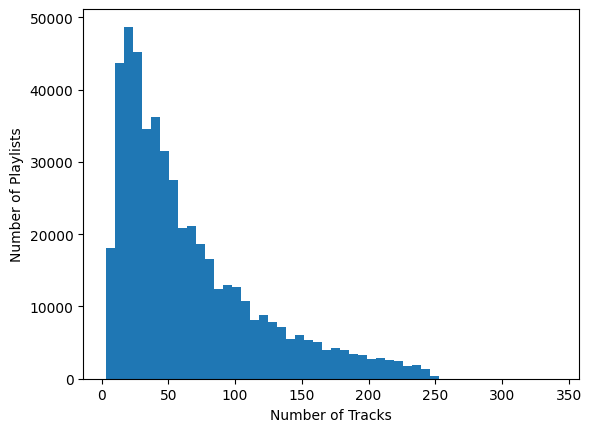

In [ ]:
# @title How many playlists share the same number of tracks, and how many tracks are in them?
playlist_counts = million_df.groupby("playlist")["track"].nunique()
playlist_counts.plot(kind="hist", bins=50, ylabel="Number of Playlists", xlabel="Number of Tracks")

In [ ]:
min_track_num = 10
max_track_num = 500
valid_playlists = playlist_counts[(playlist_counts >= min_track_num) & (playlist_counts <= max_track_num)]

<Axes: ylabel='Frequency'>

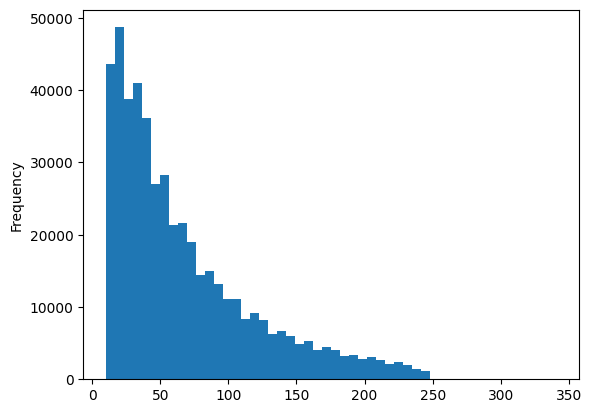

In [ ]:
valid_playlists.plot(kind="hist", bins=50)

In [ ]:
print(f"Number of Playlists goes from {playlist_counts.shape[0]} to {valid_playlists.shape[0]} (Ratio of {(valid_playlists.shape[0]/playlist_counts.shape[0])*100:.2f}%)")


Number of Playlists goes from 500000 to 481935 (Ratio of 96.39%)


In [ ]:
print(f"Before removing playlists: {million_df.shape = }")
million_df = million_df[million_df["playlist"].isin(valid_playlists.index)]
print(f"After removing playlists:  {million_df.shape = }")

Before removing playlists: million_df.shape = (32775485, 2)
After removing playlists:  million_df.shape = (32644760, 2)


### Filtering Tracks 🎶

To focus on tracks that appear in multiple playlists, we filter out tracks that are rarely used.

Steps:

  - Count playlists per track – We group tracks and count how many different playlists each track appears in.

  - Set limits for valid tracks – Tracks that appear in fewer than 50 playlists are excluded, as they are less likely to be representative for recommendations.
  
  - Filter tracks based on playlist count – We keep only tracks that appear in at least 50 playlists.

Why? 🤔

✅ Removes tracks that are too rare or not widely used.

✅ Focuses on tracks that have broader appeal across playlists.

✅ Ensures we are recommending tracks that are more likely to be relevant to users.

This step ensures that the dataset only includes tracks with significant presence in playlists. 🎵🚀

<Axes: xlabel='Tracks', ylabel='Log Number of Playlist'>

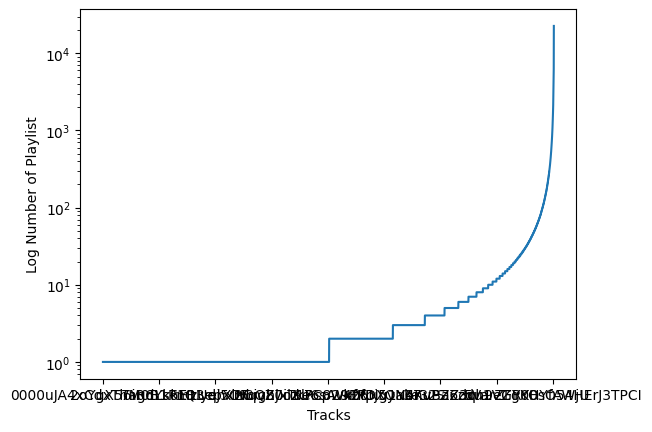

In [ ]:
# @title In how many playlists does each track appear?
track_counts = million_df.groupby("track")["playlist"].nunique()
track_counts.sort_values().plot(logy=True, ylabel="Log Number of Playlist", xlabel="Tracks")

In [ ]:
min_playlist_num = 50
valid_tracks = track_counts[(track_counts >= min_playlist_num)]

<Axes: xlabel='Tracks', ylabel='Log Number of Playlist'>

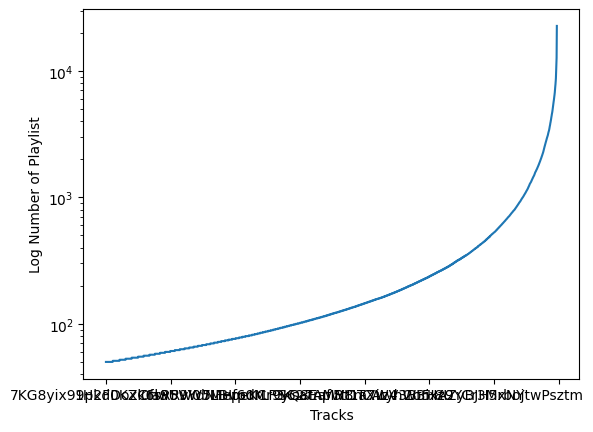

In [ ]:
valid_tracks.sort_values().plot(logy=True, ylabel="Log Number of Playlist", xlabel="Tracks")

In [ ]:
print(f"Number of Tracks goes from {track_counts.shape[0]} to {valid_tracks.shape[0]} (Ratio of {(valid_tracks.shape[0]/track_counts.shape[0])*100:.2f}%)")

Number of Tracks goes from 1603487 to 69745 (Ratio of 4.35%)


In [ ]:
print(f"Before removing tracks: {million_df.shape = }")
million_df = million_df[million_df["track"].isin(valid_tracks.index)]
print(f"After removing tracks: {million_df.shape = }")

Before removing tracks: million_df.shape = (32644760, 2)
After removing tracks: million_df.shape = (26329868, 2)


### Sparse Matrix Creation 👩‍💻

This code converts the dataset into a sparse matrix format for use in recommendation algorithms, followed by filtering and visualization steps.


  - Create Mappings for Playlist and Track Indices 🔢

      We map each unique playlist ID and track URI to a unique index.
      These mappings are used to transform the playlists and tracks into integer indices.

  - Add Indices to the DataFrame 📊

      We create two new columns in million_df for playlist indices and track indices by applying the mappings.
      These indices are used to position data in the sparse matrix.

  - Build Sparse Matrix (COO Format) 🏗️

      A COO matrix is created where each row represents a playlist, and each column represents a track.
      All values in the matrix are set to 1 (indicating that a track is part of the playlist).

  - Convert to CSR Format 💾
  
      The COO matrix is then converted to Compressed Sparse Row (CSR) format for memory efficiency and faster computation.
      The resulting matrix is printed to show its dimensions.

In [ ]:
playlist_id_to_idx = {id: idx for idx, id in enumerate(million_df["playlist"].unique())}
track_uri_to_idx = {uri: idx for idx, uri in enumerate(million_df["track"].unique())}

million_df["playlist_idx"] = million_df["playlist"].map(playlist_id_to_idx)
million_df["track_idx"] = million_df["track"].map(track_uri_to_idx)

# Create COO matrix
rows = million_df["playlist_idx"]
cols = million_df["track_idx"]
data_list = np.ones(len(million_df))  # All entries are 1 since a track belongs to a playlist

csr_rating_matrix = coo_matrix((data_list, (rows, cols)), shape=(len(playlist_id_to_idx), len(track_uri_to_idx))).tocsr()

print(csr_rating_matrix.shape)

(477866, 69745)


  - Matrix Visualization 📊
  
      The sum of each row is calculated to understand the distribution of playlist lengths.
      A histogram of the row sums is plotted in log scale to visualize the distribution of playlist sizes.

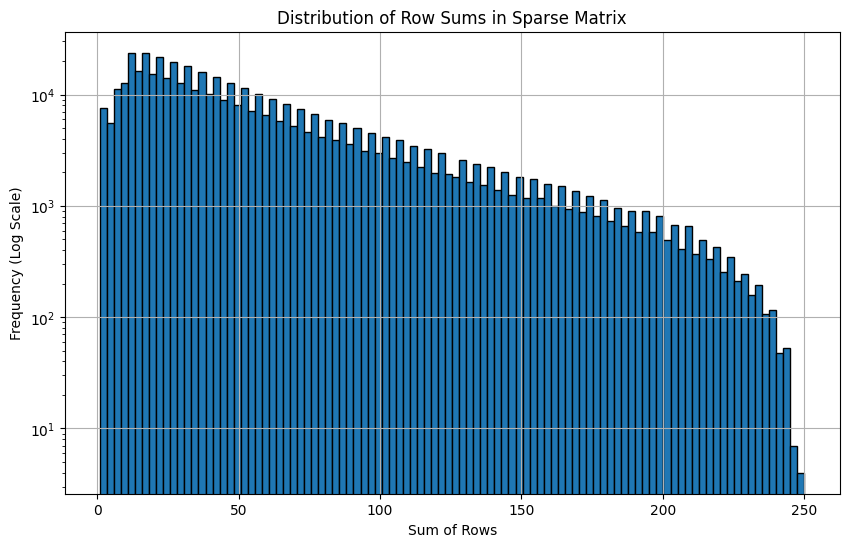

In [ ]:
import matplotlib.pyplot as plt

row_sums = np.array(csr_rating_matrix.sum(axis=1)).flatten()  # Convert to 1D NumPy array

# Plot the distribution of row sums
plt.figure(figsize=(10, 6))
plt.hist(row_sums, bins=100, log=True, edgecolor="black")  # Log scale for better visualization
plt.xlabel("Sum of Rows")
plt.ylabel("Frequency (Log Scale)")
plt.title("Distribution of Row Sums in Sparse Matrix")
plt.grid(True)
plt.show()

  - Filter Valid Rows Based on Playlist Length 🔍
  
      We filter out playlists that have fewer than 30 tracks by checking the row sums of the sparse matrix.
      The rows representing playlists with enough tracks are selected, and the order is shuffled for randomness.
      The matrix is then trimmed to a smaller size (81,000 rows) for efficient processing.

In [ ]:
row_sums = np.array(csr_rating_matrix.sum(axis=1)).flatten()

valid_rows = np.where(row_sums >= 30)[0]  # Get indices of valid rows

# Randomly shuffle valid rows
np.random.shuffle(valid_rows)  # Shuffle row indices

# Select only valid rows from CSR matrix
filtered_permuted_matrix = csr_rating_matrix[valid_rows, :]

filtered_permuted_matrix = filtered_permuted_matrix[:81_000,:]

# Check the new shape
print("Original shape:", csr_rating_matrix.shape)
print("Filtered & permuted shape:", filtered_permuted_matrix.shape)

Original shape: (477866, 69745)
Filtered & permuted shape: (81000, 69745)


Why are these steps Important? 🤔

✅ Sparse matrix format is memory-efficient and ideal for large datasets.

✅ Filtered playlists help remove small playlists that may not provide enough data for accurate recommendations.

✅ Randomization ensures that the data is shuffled for better model training.

This process prepares the dataset for use in recommendation systems by creating a compact, filtered, and shuffled matrix representation of playlists and tracks. 🎵🧠

In [ ]:
num_tracks = csr_rating_matrix.shape[1]
tracks = set(track_uri_to_idx.keys())

### Freeing RAM for Training 🧹

This code clears unnecessary variables from memory to free up space for model training:

  - Deletes large data structures like million_df and other intermediate variables.
  
  - Calls gc.collect() to ensure garbage collection and memory release.

This step ensures that there is enough available memory for the upcoming training phase. 🚀

In [ ]:
del million_df
del(playlist_counts, valid_playlists)
del(track_counts, valid_tracks)
del(rows, cols, data_list, new_data)
del playlist_id_to_idx

try:
  del(row_sums, valid_rows)
except:
  pass
gc.collect()

17404

In [ ]:
gc.collect()

42

## Model Evaluation and Metrics Definition 📊

### Precision at k
The precision at k evaluates how many of the top-k recommended items are relevant, excluding items already in the playlist. It's calculated as:
$
\text{Precision@k} = \frac{\text{Number of relevant items in top-k}}{k}
$

Where relevant items are identified based on the ground truth matrix.

### Recall at k
Recall at k measures how many of the relevant items are present in the top-k recommendations. It's calculated as:
$
\text{Recall@k} = \frac{\text{Number of relevant items in top-k}}{\text{Total number of relevant items}}
$

Where relevant items are identified in the ground truth matrix.

### Mean Reciprocal Rank (MRR)
The MRR measures how high the first relevant item appears in the list of recommendations. It’s the average of the reciprocal ranks for each playlist:
$
\text{MRR} = \frac{1}{\text{Rank of first relevant item}}
$

If no relevant item is found, the reciprocal rank is 0.

### Evaluation Process
The model is evaluated by:
1. Iterating over shuffled slices of playlists.
2. For each playlist, computing the predicted matrix for top-k recommendations.
3. Calculating Precision, Recall, and MRR for different values of k (1, 2, 5, 10).
4. Averaging the results over multiple iterations to get more robust metrics.

These metrics help assess the model's ability to recommend relevant songs while considering the existing ones in the playlist and the quality of the top-k recommendations.


In [ ]:
# @title metrics definition
def precision_at_k(predicted_matrix, ground_truth_matrix, input_matrix, k):
    """
    Calculate precision at k while excluding items that are already in the input matrix (playlist).

    Args:
    - predicted_matrix (np.ndarray): Matrix of predicted scores for each song in the playlist.
    - ground_truth_matrix (np.ndarray): Ground truth matrix with binary values indicating relevant songs.
    - input_matrix (np.ndarray): Matrix representing songs already in the playlist (binary).
    - k (int): The number of top items to consider.

    Returns:
    - float: The average precision at k, excluding already present songs.
    """
    # Create a mask for already existing items (input matrix)
    mask = input_matrix > 0  # 1 indicates the item is already in the playlist

    # Mask the predicted scores for already existing items by setting them to -inf
    masked_predictions = np.where(mask, -np.inf, predicted_matrix)

    # Use argsort to get the indices of the top k predictions after masking
    top_k_indices = np.argsort(masked_predictions, axis=1)[:, ::-1][:, :k]

    # Extract relevant items in ground truth corresponding to the top k predictions
    relevant_items = ground_truth_matrix[np.arange(ground_truth_matrix.shape[0])[:, None], top_k_indices]

    # Calculate precision as the number of relevant items divided by k
    precision_scores = np.sum(relevant_items, axis=1) / k

    # Return the average precision
    return np.mean(precision_scores)



def recall_at_k(predicted_matrix, ground_truth_matrix, input_matrix, k):
    # Mask the predictions where the input matrix has 1s (already in the playlist)
    mask = input_matrix > 0
    masked_predictions = np.where(mask, -np.inf, predicted_matrix)

    # Get the indices of the top k predictions for each row after masking
    top_k_indices = np.argsort(masked_predictions, axis=1)[:, -k:][:, ::-1]

    # Gather the relevant items in ground truth corresponding to top k predictions
    relevant_items = ground_truth_matrix[np.arange(ground_truth_matrix.shape[0])[:, None], top_k_indices]

    # Calculate the recall for each playlist
    total_relevant = np.sum(ground_truth_matrix, axis=1)  # Total relevant items per playlist

    # Avoid division by zero: mask rows with no relevant items
    recall_scores = np.sum(relevant_items, axis=1) / np.maximum(total_relevant, 1)

    # Return the mean recall, ignoring rows with no relevant items
    return np.mean(recall_scores[total_relevant > 0])



def mean_reciprocal_rank(predicted_matrix, ground_truth_matrix, input_matrix):
    reciprocal_ranks = []

    # Iterate over each playlist (row in the matrix)
    for pred_row, true_row, input_row in zip(predicted_matrix, ground_truth_matrix, input_matrix):
        # Mask the predictions where the input matrix has 1s (already in the playlist)
        mask = input_row == 1
        masked_predictions = np.where(mask, -np.inf, pred_row)

        # Get the indices sorted by predicted scores in descending order
        sorted_indices = np.argsort(masked_predictions)[::-1]

        # Find the rank of the first relevant item
        found_relevant = False
        for rank, index in enumerate(sorted_indices, start=1):
            if true_row[index] == 1:  # If the item is relevant in the ground truth
                reciprocal_ranks.append(1 / rank)
                found_relevant = True
                break

        # If no relevant items were found, append 0
        if not found_relevant:
            reciprocal_ranks.append(0)

    # Return the mean of the reciprocal ranks
    return np.mean(reciprocal_ranks)




In [ ]:
# @title evaluating function definition
def evaluate_model_k_tracks_per_playlist(model, k, num_valid_files=10):
  """
  evaluate model processing a slice of playlists, 200 playlist at time to avoid
  colab cpu overflow
  """
  # num_valid_files = 1000 - num_training_files
  precision_at_10 = np.zeros(num_valid_files)
  precision_at_5 = np.zeros(num_valid_files)
  precision_at_2 = np.zeros(num_valid_files)
  precision_at_1 = np.zeros(num_valid_files)

  recall_at_10 = np.zeros(num_valid_files)
  recall_at_5 = np.zeros(num_valid_files)
  recall_at_2 = np.zeros(num_valid_files)
  recall_at_1 = np.zeros(num_valid_files)

  mrr = np.zeros(num_valid_files)

  for file_idx, filename in enumerate(shuffled_slices[num_training_files:num_training_files+num_valid_files]):
    correct_playlists = np.zeros((1000, num_tracks))
    p_counter = -1
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
      filepath = os.path.join(data, filename)

      with open(filepath, "r", encoding="utf-8") as jsonfile:
        cur_slice = json.load(jsonfile)

      for playlist in cur_slice["playlists"]:
        p_counter += 1

        for track in playlist["tracks"]:
          track_uri = track["track_uri"][14:]

          if track_uri in tracks:
            t_idx = track_uri_to_idx[track_uri]

            correct_playlists[p_counter, t_idx] = 1


    incomplete_playlists = np.copy(correct_playlists)

    for row in incomplete_playlists:
      one_indexes = np.where(row == 1)[0]

      if len(one_indexes) >= k:
        indices_to_zero = np.random.choice(one_indexes, size=(len(one_indexes)-k), replace=False)
        row[indices_to_zero] = 0

    n_iter = 5

    cur_precision_at_10 = [0 for _ in range(n_iter)]
    cur_precision_at_5 = [0 for _ in range(n_iter)]
    cur_precision_at_2 = [0 for _ in range(n_iter)]
    cur_precision_at_1 = [0 for _ in range(n_iter)]

    cur_recall_at_10 = [0 for _ in range(n_iter)]
    cur_recall_at_5 = [0 for _ in range(n_iter)]
    cur_recall_at_2 = [0 for _ in range(n_iter)]
    cur_recall_at_1 = [0 for _ in range(n_iter)]

    cur_mrr = [0 for _ in range(n_iter)]

    size_batch = 1000 // n_iter

    for iter in range(n_iter):
      input_matrix_iter = incomplete_playlists[size_batch*iter:size_batch*(iter+1), :]
      P_new = model.transform(input_matrix_iter)

      # Predici la matrice ricostruita per le nuove playlist
      predicted_matrix = np.dot(P_new, model.components_)

      ground_truth_matrix_iter = correct_playlists[size_batch*iter:size_batch*(iter+1), :]

      cur_precision_at_10[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 10)
      cur_precision_at_5[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 5)
      cur_precision_at_2[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 2)
      cur_precision_at_1[iter] = precision_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 1)

      cur_recall_at_10[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 10)
      cur_recall_at_5[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 5)
      cur_recall_at_2[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 2)
      cur_recall_at_1[iter] = recall_at_k(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter, 1)

      cur_mrr[iter] = mean_reciprocal_rank(predicted_matrix, ground_truth_matrix_iter, input_matrix_iter)

    precision_at_10[file_idx] = np.mean(cur_precision_at_10)
    precision_at_5[file_idx] = np.mean(cur_precision_at_5)
    precision_at_2[file_idx] = np.mean(cur_precision_at_2)
    precision_at_1[file_idx] = np.mean(cur_precision_at_1)
    recall_at_10[file_idx] = np.mean(cur_recall_at_10)
    recall_at_5[file_idx] = np.mean(cur_recall_at_5)
    recall_at_2[file_idx] = np.mean(cur_recall_at_2)
    recall_at_1[file_idx] = np.mean(cur_recall_at_1)
    mrr[file_idx] = np.mean(cur_mrr)

  p10 = np.mean(precision_at_10)
  p5 = np.mean(precision_at_5)
  p2 = np.mean(precision_at_2)
  p1 = np.mean(precision_at_1)
  r10 = np.mean(recall_at_10)
  r5 = np.mean(recall_at_5)
  r2 = np.mean(recall_at_2)
  r1 = np.mean(recall_at_1)
  mrr = np.mean(mrr)

  print("  Precision@10 = ", p10)
  print("  Precision@5 = ", p5)
  print("  Precision@2 = ", p2)
  print("  Precision@1 = ", p1)
  print("  Recall@10 = ", r10)
  print("  Recall@5 = ", r5)
  print("  Recall@2 = ", r2)
  print("  Recall@1 = ", r1)
  print("  MRR = ", mrr)

  return p10, p5, p2, p1, r10, r5, r2, r1, mrr

## NMF 🔢

### How NMF (Non-negative Matrix Factorization) Works

NMF is a matrix factorization technique where a given matrix is approximated as the product of two lower-dimensional non-negative matrices. Specifically, given a matrix \( R \) (e.g., user-item ratings), NMF decomposes it into:

$$
R \approx W \times H
$$

- $ W $ is the user-feature matrix (users x latent factors).
- $ H $ is the item-feature matrix (items x latent factors).

The goal is to minimize the difference between the original matrix $ R $ and the product of $ W $ and $ H $, subject to the non-negativity constraint (all values must be >= 0). The factorization helps capture hidden patterns or latent features in the data, such as user preferences or item characteristics.

### Use in Recommender Systems

In a recommender system, NMF helps predict unknown ratings by approximating the original matrix of user-item interactions. The latent factors discovered by NMF can capture user preferences and item attributes, making it possible to recommend items (e.g., songs, movies) that are most likely to be of interest to a user based on patterns in the data.


### Training

In [ ]:
nmf_model = NMF(100, random_state=42)
nmf_model.fit(filtered_permuted_matrix)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=100, random_state=42)

Sometimes the NMF model did not reach convergence and is not performing effectively. We chose not to increase the number of iterations to save memory and avoid potential runtime issues with Colab's limited RAM. Extending iterations could lead to excessive computational overhead without guaranteeing significant improvements.

### Evaluation

In [ ]:
for k in [2, 5, 8]:
  print(f"\nValidation Metrics Keeping {k} songs per playlist:")
  evaluate_model_k_tracks_per_playlist(nmf_model, k, num_valid_files=4)


Validation Metrics Keeping 2 songs per playlist:
  Precision@10 =  0.155025
  Precision@5 =  0.17515000000000003
  Precision@2 =  0.197375
  Precision@1 =  0.208
  Recall@10 =  0.03443152019187241
  Recall@5 =  0.01988896845368552
  Recall@2 =  0.009287150370111876
  Recall@1 =  0.004932326858597184
  MRR =  0.3164658335968125

Validation Metrics Keeping 5 songs per playlist:
  Precision@10 =  0.16975
  Precision@5 =  0.19125
  Precision@2 =  0.213125
  Precision@1 =  0.2305
  Recall@10 =  0.03466052085612824
  Recall@5 =  0.02020895389283405
  Recall@2 =  0.009216530723497512
  Recall@1 =  0.005048736608569648
  MRR =  0.33907795108748123

Validation Metrics Keeping 8 songs per playlist:
  Precision@10 =  0.17245
  Precision@5 =  0.18905
  Precision@2 =  0.206375
  Precision@1 =  0.22299999999999998
  Recall@10 =  0.033278235860311166
  Recall@5 =  0.018657801012468042
  Recall@2 =  0.008147777865111937
  Recall@1 =  0.004434033242542409
  MRR =  0.33187462807464163


### Hyper-Parameter Analysis

NMF hyperparameter on model complexity, filtered matrix, 2 tracks per playlist

```
components = [2, 5, 8, 10, 20, 30, 40, 50, 70, 100, 125, 150, 175, 200, 250, 300, 600]
precision_at_10 = [0 for _ in range(len(components))]
precision_at_5 = [0 for _ in range(len(components))]
precision_at_2 = [0 for _ in range(len(components))]
precision_at_1 = [0 for _ in range(len(components))]
recall_at_10 = [0 for _ in range(len(components))]
recall_at_5 = [0 for _ in range(len(components))]
recall_at_2 = [0 for _ in range(len(components))]
recall_at_1 = [0 for _ in range(len(components))]
mrr = [0 for _ in range(len(components))]

for i, n_components in enumerate(components):
  cur_model = NMF(n_components, max_iter=1000, random_state=42)
  cur_model.fit(filtered_permuted_matrix)
  
  p10, p5, p2, p1, r10, r5, r2, r1, mr = evaluate_model_k_tracks_per_playlist(cur_model, k=2, num_valid_files=4)
  precision_at_10[i] = p10
  precision_at_5[i] = p5
  precision_at_2[i] = p2
  precision_at_1[i] = p1
  recall_at_10[i] = r10
  recall_at_5[i] = r5
  recall_at_2[i] = r2
  recall_at_1[i] = r1
  mrr[i] = mr

# Rimuovere l'8 da components per una migliore visualizzazione
x_ticks = components.copy()
x_ticks.remove(8)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Titolo
fig.suptitle("Precision, Recall e MRR rispetto alla complessità del modello", fontsize=16)
fig.text(0.5, 0.94, f"NMF model su filtered_permuted_matrix, 2 tracce per playlist", ha='center', fontsize=12, style='italic')

# Precision
ax1.plot(components, precision_at_10, marker='o', linestyle='-', label='Precision@10')
ax1.plot(components, precision_at_5, marker='s', linestyle='--', label='Precision@5')
ax1.plot(components, precision_at_2, marker='^', linestyle='-.', label='Precision@2')
ax1.plot(components, precision_at_1, marker='d', linestyle=':', label='Precision@1')
ax1.set_ylabel("Precision")
ax1.set_xticks(x_ticks)
ax1.legend()
ax1.grid(True)

# Recall
ax2.plot(components, recall_at_10, marker='o', linestyle='-', label='Recall@10')
ax2.plot(components, recall_at_5, marker='s', linestyle='--', label='Recall@5')
ax2.plot(components, recall_at_2, marker='^', linestyle='-.', label='Recall@2')
ax2.plot(components, recall_at_1, marker='d', linestyle=':', label='Recall@1')
ax2.set_ylabel("Recall")
ax2.set_xticks(x_ticks)
ax2.legend()
ax2.grid(True)

# MRR
ax3.plot(components, mrr, marker='o', linestyle='-', label='MRR', color='red')
ax3.set_ylabel("MRR")
ax3.set_xlabel("Numero di Componenti NMF")
ax3.set_xticks(x_ticks)
ax3.legend()
ax3.grid(True)

plt.show()
```

<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_MF/nmf_model_hyperparameter_complexity_filtered_2_tracks.png?raw=true" width = 90%>


We performed a hyperparameter tuning experiment to analyze how the number of **Non-Negative Matrix Factorization (NMF) components** affects the **Playlist Recommendation** performance.

🔎 **Key Observations**
1. **Precision Trends**  
   - Precision improves as the number of components increases, showing significant gains up to **100 components**.
   - The highest **Precision@1** suggests that the first recommended track is often correct.
   - Precision gains become marginal beyond **100+ components**.

2. **Recall Trends**  
   - Recall improves with more components, especially for **Recall@10**, indicating that the model retrieves more relevant tracks.
   - **Recall@1 remains low**, meaning single-item exact matches are challenging.

3. **MRR Behavior**  
   - MRR rises rapidly at first and stabilizes around **100 components**.
   - Beyond **100 components**, improvements are minor, indicating diminishing returns.

⚖️ **Key Takeaways**
- **Optimal Range:** Using **100 components** balances performance and computational cost.
- **Diminishing Returns:** Adding more than **100+ components** does not significantly boost results.
- **Efficiency Considerations:** If computation is a concern, choosing **50 components** offers a good trade-off.

## SVD 🔢

⚙️ How SVD Works

Singular Value Decomposition (SVD) is a matrix factorization technique that decomposes a given matrix $ R $ into three matrices:

$$
R \approx U \Sigma V^T
$$

- $ U $ (users x latent factors) represents user preferences.  
- $ \Sigma $ (diagonal matrix) contains singular values that represent the importance of each latent factor.  
- $ V^T $ (latent factors x items) captures item characteristics.  

Unlike NMF, SVD **does not require non-negativity constraints** and can capture more complex relationships in the data. It is computationally **more efficient** and provides **better performance** in many recommendation tasks.  

🎧 SVD in Recommender Systems

In a recommender system, SVD helps reduce the dimensionality of the user-item interaction matrix while preserving meaningful patterns. By projecting users and items into a shared latent space, **SVD enables personalized recommendations based on similarity in preferences**.  
  
✅ **Faster Computation** – SVD converges faster than NMF, especially for large matrices.  

🛠️ Implementing SVD for Playlist Recommendation

We implement SVD using a class that utilizes the **sparse SVD implementation from SciPy (`svds`)**, allowing efficient decomposition of large matrices.  

🏋️ Training SVD on Filtered and Unfiltered Matrices

We apply SVD to both the **binary rating matrix** and the **permuted and sampled rating matrix**.


In [ ]:
class ScipySVD():
  def __init__(self, n_components, **kwargs):
    self.n_components = n_components
    self.kwargs = kwargs


  def fit(self, X):
    _, _, self.components_ = svds(X, self.n_components, **self.kwargs)


  def transform(self, X):
    return X @ self.components_.T

### Training

In [ ]:
# @title SVD model on binary rating matrix
svd_model = ScipySVD(300, random_state=42)
svd_model.fit(csr_rating_matrix)

In [ ]:
# @title SVD model on permuted and sampled rating matrix
svd_model_permuted = ScipySVD(300, random_state=42)
svd_model_permuted.fit(filtered_permuted_matrix)

### Evaluation

In [ ]:
svd_models = [svd_model, svd_model_permuted]
svd_model_names = ["SVD", "SVD Permuted"]

for k in [2, 5, 8]:
  for model, model_name in zip(svd_models, svd_model_names):
    print(f"\n{model_name} Keeping {k} songs per playlist:")
    evaluate_model_k_tracks_per_playlist(model, k, num_valid_files=4)


SVD Keeping 2 songs per playlist:
  Precision@10 =  0.17120000000000002
  Precision@5 =  0.1976
  Precision@2 =  0.22999999999999998
  Precision@1 =  0.24875
  Recall@10 =  0.039987198294801095
  Recall@5 =  0.023948670642894007
  Recall@2 =  0.011357114471074447
  Recall@1 =  0.0064734851233585935
  MRR =  0.35977883082742884

SVD Permuted Keeping 2 songs per playlist:
  Precision@10 =  0.18177500000000002
  Precision@5 =  0.21125000000000005
  Precision@2 =  0.247875
  Precision@1 =  0.27175
  Recall@10 =  0.042385929248309064
  Recall@5 =  0.025499860372053165
  Recall@2 =  0.012331134798676698
  Recall@1 =  0.006949939136352647
  MRR =  0.38325908694315436

SVD Keeping 5 songs per playlist:
  Precision@10 =  0.19272499999999998
  Precision@5 =  0.21765
  Precision@2 =  0.245875
  Precision@1 =  0.261
  Recall@10 =  0.04172309273422282
  Recall@5 =  0.02427511891668023
  Recall@2 =  0.011285688674467088
  Recall@1 =  0.006157178393049989
  MRR =  0.38310450812624663

SVD Permuted K

Model performance as the number of tracks included in the playlist changes

```
best_model = ScipySVD(300, random_state=42)
best_model.fit(filtered_permuted_matrix)
tracks_included = [1, 2, 4, 8, 10, 15, 20, 30]

precision_at_10 = [0 for _ in range(len(tracks_included))]
precision_at_5 = [0 for _ in range(len(tracks_included))]
precision_at_2 = [0 for _ in range(len(tracks_included))]
precision_at_1 = [0 for _ in range(len(tracks_included))]
recall_at_10 = [0 for _ in range(len(tracks_included))]
recall_at_5 = [0 for _ in range(len(tracks_included))]
recall_at_2 = [0 for _ in range(len(tracks_included))]
recall_at_1 = [0 for _ in range(len(tracks_included))]
mrr = [0 for _ in range(len(tracks_included))]


for i, k in enumerate(tracks_included):
  evaluate_model_k_tracks_per_playlist(best_model, k, num_valid_files=4)

  p10, p5, p2, p1, r10, r5, r2, r1, mr = evaluate_model_k_tracks_per_playlist(cur_model, k, num_valid_files=4)
  precision_at_10[i] = p10
  precision_at_5[i] = p5
  precision_at_2[i] = p2
  precision_at_1[i] = p1
  recall_at_10[i] = r10
  recall_at_5[i] = r5
  recall_at_2[i] = r2
  recall_at_1[i] = r1
  mrr[i] = mr


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Title
fig.suptitle("Precision, Recall, e MRR rispetto al numero di tracce nelle playlist", fontsize=16)
fig.text(0.5, 0.94, "best SVD model on filtered_permuted_matrix", ha='center', fontsize=12, style='italic')

# Precision
ax1.plot(tracks_included, precision_10, marker='o', linestyle='-', label='Precision@10')
ax1.plot(tracks_included, precision_5, marker='s', linestyle='--', label='Precision@5')
ax1.plot(tracks_included, precision_2, marker='^', linestyle='-.', label='Precision@2')
ax1.plot(tracks_included, precision_1, marker='d', linestyle=':', label='Precision@1')
ax1.set_ylabel("Precision")
ax1.legend()
ax1.grid(True)
ax1.set_xlabel("Numero di tracce nelle playlist parziali")
ax1.set_xticks(tracks_included)

# Recall
ax2.plot(tracks_included, recall_10, marker='o', linestyle='-', label='Recall@10')
ax2.plot(tracks_included, recall_5, marker='s', linestyle='--', label='Recall@5')
ax2.plot(tracks_included, recall_2, marker='^', linestyle='-.', label='Recall@2')
ax2.plot(tracks_included, recall_1, marker='d', linestyle=':', label='Recall@1')
ax2.set_ylabel("Recall")
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("Numero di tracce nelle playlist parziali")
ax2.set_xticks(tracks_included)

# MRR
ax3.plot(tracks_included, mrr, marker='o', linestyle='-', label='MRR', color='red')
ax3.set_ylabel("MRR")
ax3.set_xlabel("Numero di tracce nelle playlist parziali")
ax3.set_xticks(tracks_included)
ax3.legend()
ax3.grid(True)

plt.show()
```

<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_MF/best_svd_model_on_playlist_tracks.png?raw=true" width = 90%>

🔍 Observations

1. **Precision Trends**  
   - Precision generally **increases** as the number of known tracks grows up to around **8-10 tracks**.  
   - Beyond this point, performance **declines**, suggesting that additional tracks may introduce more noise or redundancy rather than improving recommendation accuracy.  
   - **Precision@1** achieves the highest values, while **Precision@10** is lower but follows a similar pattern.

2. **Recall Behavior**  
   - Recall also **peaks at around 4-8 tracks** and starts declining afterward.  
   - The drop beyond **10 tracks** suggests that the model struggles to maintain high recall when playlists are more complete, likely because the remaining missing tracks are more difficult to predict.

3. **MRR (Mean Reciprocal Rank) Trends**  
   - **MRR exhibits a clear peak at around 8 tracks**, meaning the model ranks relevant items most accurately when 8 tracks are available.  
   - The **drop in MRR beyond 10 tracks** suggests that recommendations become less reliable when the playlist is too complete, likely because fewer missing tracks make the ranking task harder.

📌 Key Takeaways  

✅ **Best Performance at 8 Tracks** – Precision, Recall, and MRR indicate that **SVD performs best when playlists have 8 known tracks**, as this balances available information and the ability to generalize missing items.  

⚠️ **Decreasing Performance for Larger Playlists** – When playlists have **15-20 known tracks**, precision, recall, and MRR all decline, suggesting that additional tracks do not contribute significantly to better recommendations and may introduce noise.  


### Hyper-Parameter Analysis

How does the performance change on the standard binary matrix as the SVD model complexity (number of principal components taken) changes.

```
components = [5, 10, 20, 30, 40, 50, 70, 100, 125, 150, 175, 190, 200, 220, 240, 300, 600]

precision_at_10 = [0 for _ in range(len(components))]
precision_at_5 = [0 for _ in range(len(components))]
precision_at_2 = [0 for _ in range(len(components))]
precision_at_1 = [0 for _ in range(len(components))]
recall_at_10 = [0 for _ in range(len(components))]
recall_at_5 = [0 for _ in range(len(components))]
recall_at_2 = [0 for _ in range(len(components))]
recall_at_1 = [0 for _ in range(len(components))]
mrr = [0 for _ in range(len(components))]

for i, n_components in enumerate(components):
  cur_model = ScipySVD(n_components, random_state=42)
  cur_model.fit(filtered_permuted_matrix)
  
  p10, p5, p2, p1, r10, r5, r2, r1, mr = evaluate_model_k_tracks_per_playlist(cur_model, k=2, num_valid_files=4)
  precision_at_10[i] = p10
  precision_at_5[i] = p5
  precision_at_2[i] = p2
  precision_at_1[i] = p1
  recall_at_10[i] = r10
  recall_at_5[i] = r5
  recall_at_2[i] = r2
  recall_at_1[i] = r1
  mrr[i] = mr


# Creazione dei subplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Titolo principale
fig.suptitle("Precision, Recall e MRR rispetto alla complessità del modello", fontsize=16)
fig.text(0.5, 0.94, f"SVD matrice dei rating di dimensione {csr_rating_matrix.shape}", ha='center', fontsize=12, style='italic')
fig.text(0.5, 0.915, f"Playlist incomplete con solo 2 tracce ciascuna", ha='center', fontsize=12, style='italic')

# Plot Precision
ax1.plot(components, precision_at_10, marker='o', linestyle='-', label='Precision@10')
ax1.plot(components, precision_at_5, marker='s', linestyle='--', label='Precision@5')
ax1.plot(components, precision_at_2, marker='^', linestyle='-.', label='Precision@2')
ax1.plot(components, precision_at_1, marker='d', linestyle=':', label='Precision@1')
ax1.set_ylabel("Precision")
ax1.legend()
ax1.grid(True)

# Plot Recall
ax2.plot(components, recall_at_10, marker='o', linestyle='-', label='Recall@10')
ax2.plot(components, recall_at_5, marker='s', linestyle='--', label='Recall@5')
ax2.plot(components, recall_at_2, marker='^', linestyle='-.', label='Recall@2')
ax2.plot(components, recall_at_1, marker='d', linestyle=':', label='Recall@1')
ax2.set_ylabel("Recall")
ax2.legend()
ax2.grid(True)

# Plot MRR
ax3.plot(components, mrr, marker='o', linestyle='-', label='MRR', color='red')
ax3.set_ylabel("MRR")
ax3.set_xlabel("Number of SVD Components")
ax3.legend()
ax3.grid(True)

# Mostra il grafico
plt.show()
```
<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_MF/svd_model_hyperparameter_complexity_2_tracks.png?raw=true" width=90%>


How does the performance change on the filtered matrix as the SVD model complexity (number of principal components taken) changes.

```
components = [5, 10, 20, 30, 40, 50, 70, 100, 125, 150, 175, 200, 250, 300, 600]

precision_at_10 = [0 for _ in range(len(components))]
precision_at_5 = [0 for _ in range(len(components))]
precision_at_2 = [0 for _ in range(len(components))]
precision_at_1 = [0 for _ in range(len(components))]
recall_at_10 = [0 for _ in range(len(components))]
recall_at_5 = [0 for _ in range(len(components))]
recall_at_2 = [0 for _ in range(len(components))]
recall_at_1 = [0 for _ in range(len(components))]
mrr = [0 for _ in range(len(components))]

for i, n_components in enumerate(components):
  cur_model = ScipySVD(n_components, random_state=42)
  cur_model.fit(filtered_permuted_matrix)
  
  p10, p5, p2, p1, r10, r5, r2, r1, mr = evaluate_model_k_tracks_per_playlist(cur_model, k=2, num_valid_files=4)
  precision_at_10[i] = p10
  precision_at_5[i] = p5
  precision_at_2[i] = p2
  precision_at_1[i] = p1
  recall_at_10[i] = r10
  recall_at_5[i] = r5
  recall_at_2[i] = r2
  recall_at_1[i] = r1
  mrr[i] = mr


# Create subplots in 3 rows, 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Set main title
fig.suptitle("Precision, Recall e MRR rispetto alla complessità del modello", fontsize=16)
fig.text(0.5, 0.94, f"SVD matrice filtrata di dimensione {filtered_permuted_matrix.shape}",
         ha='center', fontsize=12, style='italic')

# Plot Precision
ax1.plot(components, precision_at_10, marker='o', linestyle='-', label='Precision@10')
ax1.plot(components, precision_at_5, marker='s', linestyle='--', label='Precision@5')
ax1.plot(components, precision_at_2, marker='^', linestyle='-.', label='Precision@2')
ax1.plot(components, precision_at_1, marker='d', linestyle=':', label='Precision@1')
ax1.set_ylabel("Precision")
ax1.legend()
ax1.grid(True)

# Plot Recall
ax2.plot(components, recall_at_10, marker='o', linestyle='-', label='Recall@10')
ax2.plot(components, recall_at_5, marker='s', linestyle='--', label='Recall@5')
ax2.plot(components, recall_at_2, marker='^', linestyle='-.', label='Recall@2')
ax2.plot(components, recall_at_1, marker='d', linestyle=':', label='Recall@1')
ax2.set_ylabel("Recall")
ax2.legend()
ax2.grid(True)

# Plot MRR
ax3.plot(components, mrr, marker='o', linestyle='-', label='MRR', color='red')
ax3.set_ylabel("MRR")
ax3.set_xlabel("Number of SVD Components")
ax3.legend()
ax3.grid(True)

plt.show()
```

<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_MF/svd_model_hyperparameter_complexity_filtered_2_tracks.png?raw=true" width=90%>

We performed a hyperparameter tuning experiment to analyze how the number of **SVD components** affects the **Playlist Recommendation** performance on each the standard  and filtered matrices.

🔎 **Key Observations**
1. **Precision & Recall Trends**  
   - Precision and Recall improve as the number of components increases, showing significant gains up to **300 components**.
   - Precision and Recall gain become marginal beyond **300+ components**.

2. **MRR Behavior**  
   - MRR rises rapidly at first and stabilizes around **200 components**.
   - Beyond **300 components**, improvements are minor, indicating diminishing returns.

⚖️ **Key Takeaways**
- **Optimal Range:** Using **300 components** balances performance and computational cost.
- **Diminishing Returns:** Adding more than **300+ components** does not significantly boost results.
- **Efficiency Considerations:** If computation is a concern, choosing around** 100 components** offers a good trade-off.

How does the SVD performance change on the filtered matrix as we change the treshold for **minimum tracks in playlists**?
<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_MF/best_svd_model_different_dataset_track_threshold.png?raw=true" width=90%>

🔎 **Key Observations**  

1. **Precision & MRR**  
   - On both the standard and the filtered matrix, we can see that **Precision and MRR decline as we raise the filtering threshold**.  
   - However, the drop is **not significant** until we select ⚠ **extreme** values.  
   - This suggests that we can work with **far fewer tracks** (from 263,387 to just 6,288!) without losing much information, which is a major advantage in terms of computational efficiency.  

2. **Recall**  
   - Recall **initially improves** as the threshold increases, peaking at **5000 tracks** before declining at **10,000 tracks**.  
   - This behavior suggests that **removing extremely small playlists helps the model generalize better**, as it focuses on more structured user preferences rather than noisy, one-off interactions.  
   - However, when we set the threshold **too high (10,000)**, we likely remove **too much diversity**, which reduces the model’s ability to recommend long-tail tracks that are less frequently interacted with.  
   - This highlights a trade-off: **some filtering helps improve recommendations**, but **over-filtering can reduce generalization and lead to overfitting on popular items**.  


## Conclusions
### 💫 Overview of Approaches
We implemented and compared two matrix factorization techniques for playlist recommendation:
- Non-negative Matrix Factorization (NMF)
- Singular Value Decomposition (SVD)

### 📊 Key Findings

#### 🔍 Model Performance
- **SVD Performance**:
  - Demonstrated superior performance across all metrics
  - Achieved better results with both standard and filtered matrices
  - Showed more stable learning curves
- **NMF Performance**:
  - Provided solid baseline results
  - Required more components to achieve comparable performance
  - Showed more sensitivity to the number of components

#### ⏳ Running Time Comparison: SVD vs NMF
- SVD is considerably faster than NMF, especially for large datasets.
- This is because the `scipy.sparse.linalg.svds` implementation of SVD is highly optimized for handling sparse matrices.
- In contrast, NMF does not leverage sparse matrix structures as efficiently as SVD and relies on iterative updates, which are computationally expensive, particularly for high-dimensional data.
- For example, on the same matrix, SVD with 600 components takes only 15 minutes, while NMF with 200 components takes almost an hour.

#### ⚙️ Optimal Parameters
- **SVD**:
  - Optimal performance at 300 components
  - Significant improvements up to 200-300 components
  - Diminishing returns beyond 300 components
- **NMF**:
  - Best results with 100 components
  - Performance plateaus after 100 components
  - More computationally intensive than SVD

#### 🎵 Playlist Length Impact
- **Optimal Known Tracks**: 8 tracks provided the best balance for recommendations. This is likely because there are enough tracks in the incomplete playlists to understand what comes next, while also leaving enough room for tracks that could fit into the playlist.
- **Performance Pattern**:
  - Improved steadily up to 8 tracks
  - Peaked at 8-10 tracks
  - Declined with more than 10 tracks
- **Trade-off**: More tracks don't always mean better recommendations

### 💡 Key Insights
1. **Matrix Filtering**:
   - Reducing matrix size through filtering maintained performance while improving efficiency
   - Optimal threshold found at ~5000 tracks
   - Extreme filtering (>10,000) reduced model effectiveness

2. **Computational Efficiency**:
   - SVD proved more computationally efficient
   - Achieved better results with fewer components
   - More suitable for large-scale deployment

3. **Recommendation Quality**:
   - Both methods showed strong performance in capturing playlist patterns
   - SVD better at handling sparse data
   - More consistent recommendations across different playlist sizes

### 🚀 Future Improvements
1. **Hybrid Approaches**:
   - Combine SVD with content-based features
   - Incorporate temporal aspects of playlist creation
   - Explore ensemble methods

2. **Scalability**:
   - Implement incremental learning for new playlists
   - Optimize memory usage for larger datasets
   - Explore distributed computing solutions

# 💣 Bonus: Language Model Approach

## Building dependencies

In [ ]:
# File handling
import os
import json
import kagglehub

# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset

# Utils & visualization
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Approach Overview 🎶🚀

This project leverages a language model–inspired approach to predict the next song in a Spotify playlist. In natural language processing, a character-based language model predicts the next character in a sequence based on its context. Here, each “character” represents an individual song within a playlist. Essentially, the model learns to predict the subsequent song given a fixed context of preceding tracks.

At the core of our method is a Multi-Layer Perceptron (MLP) enhanced with Batch Normalization (BN). The BN layers play a critical role in stabilizing and accelerating the training process by normalizing the inputs at each layer, thereby reducing issues such as vanishing or exploding gradients. This design choice allows our relatively simple MLP to converge more reliably and efficiently.

A significant challenge in our project was the limited computational resources available, particularly with respect to GPU. Since we wanted to investigate further this approach, we invested $10 in renting a high-performance GPU (NVIDIA H200 SXM) through RunPod’s Pod. (A RunPod’s Pod is a cloud-based GPU rental service that provides on-demand access to powerful GPU resources).

This was how our pod was looking like:

<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_LM/Pod_settings.png?raw=true">

However, using this service we encountered another critical challenge. In fact, both the RAM and VRAM available on the pod are limited. The RAM allocation is really modest, and the VRAM is insufficient to load the entire dataset into the GPU memory at once. To address these issues, we implemented a data streaming strategy: rather than loading the full dataset into memory, we stream the data directly from disk (stored on the pod’s purchased volume). This approach enables us to process large volumes of data efficiently without exceeding memory constraints.

## Data Loading: Streaming with a Generator 🗂️



In [ ]:
# --- Data Loading ---
num_slices = 1000      # number of slices to load
num_playlists = 1000   # number of playlists for each slice

In [ ]:
# Downloading using kagglehub utils
path = "/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1"
if not os.path.exists(path):
  path = kagglehub.dataset_download("himanshuwagh/spotify-million")

In [ ]:
data_dir = os.path.join(path, "data")

In [ ]:
slices = sorted(os.listdir(data_dir))[:num_slices]
slices[0]

The dataset is too large to fit in the pod's memory. Instead of reading the entire JSON files at once, we define a generator (playlist_generator) that sequentially reads each file and yields one playlist at a time. This design minimizes the memory footprint because it only holds a small portion of the dataset in RAM at any given moment.

In [ ]:
def playlist_generator(data_dir, slices, num_playlists):
    """
    For each file in the list of slices,
    open the JSON file and yield one playlist at a time (up to num_playlists per file).

    Technical Details:
    - Uses a generator to avoid loading the entire dataset into memory.
    - Iterates over each JSON file ('slice') and then iterates over playlists.
    - Yields one playlist at a time, ensuring memory usage is kept minimal.
    """
    for slice_file in slices:
        file_path = os.path.join(data_dir, slice_file)
        with open(file_path, "r") as f:
            data = json.load(f)
        # Yield each playlist (up to num_playlists per slice)
        for playlist in data['playlists'][:num_playlists]:
            yield playlist

## Vocabulary Construction in Streaming Mode 📚

A key preprocessing step is building a vocabulary of unique track names. Since the dataset is huge, the vocabulary is built on-the-fly using the generator to iterate through playlists. This allows memory optimization: by streaming data, we avoid the need to hold the entire dataset in memory.

Note that the special token "." is reserved as both the start and stop token. By forcing it to index 0, we ensure a consistent representation in the model for future use. Instead, sorting the unique track names before enumerating guarantees that the mapping is deterministic.

In [ ]:
def build_vocab(data_dir, slices, num_playlists):
    unique_tracks = set()
    for playlist in playlist_generator(data_dir, slices, num_playlists):
        # Each playlist contains a list of tracks (dictionaries with key 'track_name')
        for track in playlist['tracks']:
            unique_tracks.add(track['track_name'])
    # If the stop token is present, remove it to re-add it as token 0
    if '.' in unique_tracks:
        unique_tracks.remove('.')
    # Assign indices: the token '.' (stop/start) will have index 0
    stoi = {track: i+1 for i, track in enumerate(sorted(unique_tracks))}
    stoi['.'] = 0
    itos = {i: track for track, i in stoi.items()}
    return stoi, itos

In [ ]:
# Mapping track_names to integers (stoi) and viceversa (itos)
stoi, itos = build_vocab(data_dir, slices, num_playlists)       # build the vocabulary without loading all data into memory
vocab_size = len(itos)

In [ ]:
vocab_size

## Custom IterableDataset for On-the-fly Data Generation 🔄

We define a custom IterableDataset to generate training examples on the fly. For each playlist, a sliding window (of length block_size) is maintained. Initially, the context is padded with the start/stop token ('.' --> 0). As we iterate through the playlist, the context is updated by shifting left and appending the current token.
This allows dynamic generation of training pairs (context, target) without storing entire sequences in memory.

In [ ]:
# %% [code]
# ### Custom IterableDataset for On-the-fly Example Generation 🔄
class PlaylistsIterableDataset(IterableDataset):
    def __init__(self, data_dir, slices, num_playlists, stoi, block_size):
        """
        - data_dir: directory containing the JSON files.
        - slices: list of files to process.
        - num_playlists: number of playlists to consider per file.
        - stoi: dictionary mapping track -> index.
        - block_size: context length (in number of characters).
        """
        self.data_dir = data_dir
        self.slices = slices
        self.num_playlists = num_playlists
        self.stoi = stoi
        self.block_size = block_size

    def __iter__(self):
        """
        Given a sequence of characters, we want to predict the next character in the sequence.
        i.e:
        playlist = [let it be, hey jude] we have:
        X = [[.,.,.,.,.],                            Y = [let it be,
            [.,.,.,.,let it be],                         hey jude,
            [.,.,.,let it be, hey jude]                  .]

        (remember that '.' is the start/stop token, here context length is 5)
        """
        # For each playlist, generate examples for the language model
        for playlist in playlist_generator(self.data_dir, self.slices, self.num_playlists):
            # Initialize context with the stop token (0)
            context = [0] * self.block_size
            # Append the stop token at the end of the playlist to mark the end
            # Note: the playlist contains dictionaries for tracks
            for track in playlist['tracks'] + ['.']:
                # If track is a dictionary, extract 'track_name'
                if isinstance(track, dict):
                    track_name = track['track_name']
                else:
                    track_name = track
                # Get the index from the vocabulary (if not found, default is 0)
                ix = self.stoi.get(track_name, 0)
                # Yield a pair (context, target) as tensors
                yield torch.tensor(context, dtype=torch.long), torch.tensor(ix, dtype=torch.long)
                # Update the context: shift left and append the current token
                context = context[1:] + [ix]

## Dataset Splitting and DataLoader Setup 📊

The dataset is split at the file level into training (80%), validation (10%), and test (10%) sets. This approach ensures that entire slices (i.e., groups of playlists) are kept together.

The DataLoader wraps the custom IterableDataset. Since shuffling is not available for an IterableDataset, the training order is determined by the order in which data is generated.

The DataLoader uses a fixed batch_size to balance training speed with memory consumption.

In [ ]:
# Context Length: how many songs are we looking when predicting the next one?
block_size = 5

# Split the data
n = len(slices)
train_slices = slices[:int(0.8 * n)]
val_slices   = slices[int(0.8 * n):int(0.9 * n)]
test_slices  = slices[int(0.9 * n):]

batch_size = 32

# Create iterable datasets for each split
train_dataset = PlaylistsIterableDataset(data_dir, train_slices, num_playlists, stoi, block_size)
val_dataset   = PlaylistsIterableDataset(data_dir, val_slices, num_playlists, stoi, block_size)
test_dataset  = PlaylistsIterableDataset(data_dir, test_slices, num_playlists, stoi, block_size)

# Create DataLoaders
# Note: global shuffling is not available for an IterableDataset since data is generated on the fly
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

## Model Architecture: PlaylistModel 🧠

- Embedding Layer: Converts discrete token indices (tracks) into dense vectors of size n_embd.

- Flattening: The context, which is a sequence of tokens, is flattened (concatenated) into a single vector to feed into the MLP.

----

MLP Design:

- Multiple linear layers interleaved with Batch Normalization and Tanh activations are used.
- Batch Normalization helps in stabilizing training by normalizing the outputs of intermediate layers. It is particularly useful here since it is a deep networks, in order to prevent gradients from vanishing or exploding.
- Omitting biases in linear layers since Batch Normalization introduces its own learnable bias parameters.
- The final BN layer’s weights are scaled down (multiplied by 0.1) to control the output magnitude before the final prediction.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
class PlaylistModel(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_hidden):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.block_size = block_size
        self.mlp = nn.Sequential(
            nn.Linear(n_embd * block_size, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, vocab_size, bias=False),
            nn.BatchNorm1d(vocab_size)
        )
        # Scale down the final BN layer weights to control the output magnitude
        final_bn = self.mlp[-1]
        final_bn.weight.data.mul_(0.1)

    def forward(self, x):
        emb = self.embedding(x)                     # -> (batch_size, block_size, n_embd)
        emb = emb.view(emb.size(0), -1)             # -> (batch_size, block_size * n_embd)
        logits = self.mlp(emb)                      # -> (batch_size, vocab_size)
        return logits

In [ ]:
n_embd = 100              # embedding dimension
n_hidden = 100
model = PlaylistModel(vocab_size, n_embd, block_size, n_hidden).to(device)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

## Training Setup and Evaluation Function ⚙️

- We use Stochastic Gradient Descent (SGD) with an initial learning rate of 0.1. After a specified number of steps (numb_step_change), the learning rate is decreased to 0.01 to refine the convergence.

- The Evaluation Function is used to track stats during training with respect to training and validation sets. It calculates the loss (Cross-entropy) over full datasets.
   
	- To speed up the execution: Caching. The function caches the validation data on the CPU to avoid repeatedly transferring data from disk.
	- Chunking: To prevent VRAM overflow, the data is processed in chunks (of size chunk_size). This chunk-wise processing ensures that only a manageable subset of data is transferred to the GPU at any time.
	- Loss Calculation: Cross-entropy loss is computed and summed over each chunk, then averaged over the total number of samples.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
numb_step_change = 18000

@torch.no_grad()
def evaluate_loss(loader, chunk_size=1024):
    # Cache the validation data in CPU memory (if not already cached)
    if not hasattr(evaluate_loss, "cached_data_cpu"):
        xs_list, ys_list = [], []
        for xb, yb in loader:
            xs_list.append(xb)
            ys_list.append(yb)
        xs_cpu = torch.cat(xs_list, dim=0)
        ys_cpu = torch.cat(ys_list, dim=0)
        evaluate_loss.cached_data_cpu = (xs_cpu, ys_cpu)

    xs_cpu, ys_cpu = evaluate_loss.cached_data_cpu
    total_loss = 0.0
    total_samples = xs_cpu.size(0)

    # Process data in chunks to avoid saturating VRAM
    for i in range(0, total_samples, chunk_size):
        # Transfer only the current chunk to the GPU
        x_chunk = xs_cpu[i:i+chunk_size].to(device, non_blocking=True)
        y_chunk = ys_cpu[i:i+chunk_size].to(device, non_blocking=True)

        logits = model(x_chunk)
        loss = F.cross_entropy(logits, y_chunk, reduction='sum')
        total_loss += loss.item()

    return total_loss / total_samples

## Training Loop 🏋️‍♂️

We iterate over batches provided by the train_loader and perform a forward pass, compute the loss, backpropagate the gradients, and update the model parameters.

The training loop is governed by a maximum number of steps (max_steps), which allows control over training duration.

Data is transferred to the GPU per batch to respect VRAM limitations.

---------------------

Since the training was performed on RunPod, we insert the code here as a non executable cell.



```
max_steps = 20000
log_interval = 1000
step = 0
train_loss_history = []
val_loss_history = []
steps_list = []

model.train()

while step < max_steps:
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss_history.append(loss.item())
        step += 1

        if step == numb_step_change:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01

        if step % log_interval == 0:
            val_loss = evaluate_loss(val_loader)
            steps_list.append(step)
            val_loss_history.append(val_loss)
            print(f'{step:7d}/{max_steps:7d}: Train loss = {loss.item():.4f}, Val loss = {val_loss:.4f}')

        if step >= max_steps:
            break
```



This were the stats of approximately 1hr training (20,000 iterations).

<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_LM/Loss_during_training.jpg?raw=true" width="470">

## Plotting Training and Validation Loss 📈

Visualizing the training and validation loss over time.



```
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label="Train Loss", alpha=0.6)
plt.plot(steps_list, val_loss_history, 'ro-', label="Validation Loss", markersize=5)
plt.xlabel("Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
```


<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_LM/Loss_training_plot.png?raw=true">


The strong noise in the plot is due to the training performed using batches. In fact `batch_size = 32` is incredibly smaller compared to the amount of data in the train set. But as numbers do not lie, from the stats tracked during training we can see that both train and validation losses decrease as training iterations increase.

## Test Set Evaluation: Precision, Recall, and MRR 📊

Beyond the loss, we compute additional metrics on the test set:




```
k_values = [1, 2, 3, 5]
model.eval()

total_loss = 0.0
total_samples = 0

# Accumulators for precision and recall for each k
precision_sum = {k: 0.0 for k in k_values}
recall_sum    = {k: 0.0 for k in k_values}
mrr_sum = 0.0

with torch.no_grad():
    for xb, yb in test_loader:
        # Transfer the current batch to the GPU
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)  # logits: (batch_size, vocab_size)
        batch_size = xb.size(0)
        total_samples += batch_size
        
        # Compute loss for the batch (summed, then averaged later)
        loss = F.cross_entropy(logits, yb, reduction='sum')
        total_loss += loss.item()
        
        # Compute top k predictions: calculate only once for the maximum k needed
        max_k = max(k_values)
        # topk_indices: (batch_size, max_k)
        _, topk_indices = torch.topk(logits, max_k, dim=1, largest=True)
        
        # Compute precision and recall for each k
        for k in k_values:
            topk = topk_indices[:, :k]
            # Check if the target is among the top k predictions
            correct = (topk == yb.unsqueeze(1)).any(dim=1).float()
            precision_sum[k] += (correct / k).sum().item()
            recall_sum[k]    += correct.sum().item()
        
        # Compute Mean Reciprocal Rank (MRR) for the batch
        # Get the logit corresponding to the target for each example
        true_logits = logits.gather(1, yb.unsqueeze(1))
        # Calculate the rank: number of classes with logit >= target's logit
        ranks = (logits >= true_logits).sum(dim=1).float()
        mrr_sum += (1.0 / ranks).sum().item()

# Final computation of metrics
test_loss = total_loss / total_samples
print("Test Loss:", test_loss)

for k in k_values:
    precision_at_k = precision_sum[k] / total_samples
    recall_at_k    = recall_sum[k] / total_samples
    print(f"Precision@{k}: {precision_at_k:.4f}, Recall@{k}: {recall_at_k:.4f}")

mrr = mrr_sum / total_samples
print(f"MRR: {mrr:.4f}")


```



Obtaining the following results:


<img src="https://github.com/andrea-gentilini/PlaylistGenerator/blob/main/Images_LM/Test_metrics.png?raw=true" width="450">

## Improvements 🎉🚀

This innovative approach to next-song prediction using a language-model–inspired framework lays a robust foundation for further experimentation and enhancements.

The primary reason we did not extend our experiments was the high computational cost—prolonged GPU rentals would have been required for more extensive exploration.

If additional resources were available, our next steps would include:

- **Exploring Alternative Optimizers**:
Observations during training indicate that the loss value significantly improves during the later iterations, that is when we reduce the learning rate from 0.1 to 0.01. This suggests that the learning rate schedule is critical. Employing adaptive optimizers like Adam, which continuously adjust the learning rate during training, or performing a systematic search for the optimal learning rate could lead to substantial performance gains.

- **Hyperparameter Tuning**:
Conducting a thorough hyperparameter search (via grid search, randomized search, or Bayesian optimization) for parameters such as `n_embd` (embedding dimension) and `block_size` (context length) could further optimize the model.

- **Vocabulary Optimization**:
Reducing the vocabulary by filtering out infrequent songs (e.g., those that appear in only one playlist) could significantly decrease the size of the weight matrices. This reduction would not only speed up training but also potentially improve model performance by focusing on more representative and relevant tracks.

- **Extended Training Duration**:
Finally, training for more epochs is essential. Extended training would allow the model to learn more complex patterns and generalize better to unseen data, further enhancing its predictive accuracy.

